In [1]:
import serial
import os
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

<IPython.core.display.Javascript object>


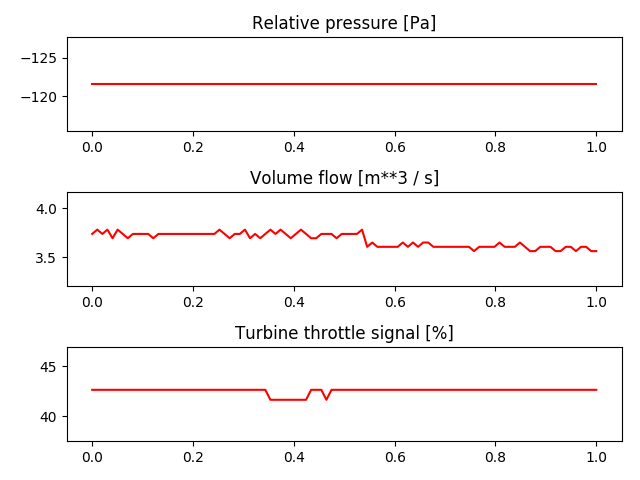

hit


In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
# dimensions of venturi tube
r1 = 2.5*10**-2 # m
A1 = np.pi*r1**2
r2 = 1*10**-2
A2 = np.pi*r2**2
def convertAnalogMPXtoDifferentialKpa(integer):
    # Input is 0- 255. If input is 42, pressure difference (and FLOW) is 0
    V_out = 5*integer/255
    V_s = 5
    P = ((V_out / V_s)-0.04)/0.09
    rho=1.204 #kg/m3 at 20 deg C
    flow_rate = A1*np.sqrt((2/rho)*P/(((A1/A2)**2) - 1))
    return P
def convertBMPReading(integer):
    out =  -1000 + 8000*integer/255
    # If integer is 255, rel. pressure is 8000 Pascals.
    # If integer is 0, rel. pressure is -1000 Pascals.
    return out
x_pr = np.linspace(0,1,100)
prev_pressures = np.zeros(100)
prev_flows = np.zeros(100)
prev_controls = np.zeros(100)

prev_control_command = 0

plt.ion()

fig,ax = plt.subplots(3,1)
ax[0].set_ylim(0,255)

ax[1].set_ylim(0,255)
print("hit")
line1, = ax[0].plot(x_pr, prev_pressures, 'r-') # Returns a tuple of line objects, thus the comma
line2, = ax[1].plot(x_pr, prev_flows, 'r-') # Returns a tuple of line objects, thus the comma
line3, = ax[2].plot(x_pr, prev_controls, 'r-') # Returns a tuple of line objects, thus the comma
ax[0].set_title('Relative pressure [Pa]')
ax[1].set_title('Volume flow [m**3 / s]')
ax[2].set_title('Turbine throttle signal [%]')
devname  = os.listdir('/dev/serial/by-id/') [0] # Try to automatically find arduino adress.
plt.tight_layout()
with serial.Serial('/dev/serial/by-id/'+devname, 9600, timeout=10) as ser:

    while True:
        try:
            line = ser.readline().decode('utf-8')   # read a '\n' terminated line
        except:
            #print(line)
            line = "0"
        #line = int(re.sub(r'[^\d-]+', '', line))

        if len(line)>2:
            if int(line)>=253:
                # Control command
                prev_control_command=int(line)
                #print(line)
            else:
                if prev_control_command ==253:
                    #print(line)
                    prev_pressures=np.roll(prev_pressures,-1)
                    prev_pressures[-1] = convertBMPReading(int(line))
                    line1.set_ydata(prev_pressures)
                    ax[0].set_ylim(0.95*np.min(prev_pressures),1.05*np.max(prev_pressures))
                    
                    fig.canvas.draw()
                    #fig.canvas.flush_events()
                
                if prev_control_command==254:
                    prev_flows = np.roll(prev_flows,-1)
                    #prev_flows[-1] = line
                    prev_flows[-1] = convertAnalogMPXtoDifferentialKpa(int(line))
                    line2.set_ydata(prev_flows)
                    #ax.set_ylim(0.9*np.min(prev_pressures),1.1*np.max(prev_pressures))
                    ax[1].set_ylim(0.9*np.min(prev_flows),1.1*np.max(prev_flows))
                    fig.canvas.draw()
                if prev_control_command==255:
                    prev_controls = np.roll(prev_controls,-1)
                    prev_controls[-1] = int(line)-128/1.1 # Sedaj je normalizirano med 0 in 100
                    line3.set_ydata(prev_controls)
                    #ax.set_ylim(0.9*np.min(prev_pressures),1.1*np.max(prev_pressures))
                    ax[2].set_ylim(0.9*np.min(prev_controls),1.1*np.max(prev_controls))
                    fig.canvas.draw()